In [1]:
!pip install mlxtend --user
!pip install lightgbm --user
!pip install xgboost --user
!pip install plotly --user

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [1]:
import os

cwd=os.path.abspath('')
os.chdir('/mnt')
files=os.listdir(cwd)

In [2]:
import os
import pandas as pd
import scipy as sp
import numpy as np
import math
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings('ignore')

In [3]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))

def mae(y, y_pred):
    return np.mean(np.absolute(np.subtract(y, y_pred)))

In [17]:
###############
### BUILD 1 ###
###############

#Yeo-Johnson Scaling
df = pd.read_csv('/mnt/Datasets/merged_df_1_27_23.csv').drop(columns = ['Unnamed: 0'])
df = df.drop(columns = ['Field_Name'])

#water = 350 mm
df = df[df['Total_Water_Applied_mm'] == 450].reset_index(drop = True)
df = df.drop(columns = ['Total_Water_Applied_mm'])

#filter outliers
df = df[(df['Yield_kg_per_Ha'] > df['Yield_kg_per_Ha'].quantile(.05)) \
                                                               & (df['Yield_kg_per_Ha'] < df['Yield_kg_per_Ha'].quantile(.95))].reset_index(drop = True)

# print(df.head(20))

# print(df.columns)

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df, test_size = 0.2, random_state = 60)

#x values
X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])
X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])

standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)

power_transform_X = PowerTransformer(standardize = True).fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = power_transform_X.transform(X_train_Yield_kg_per_ha)

X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)
X_test_Yield_kg_per_ha = power_transform_X.transform(X_test_Yield_kg_per_ha)

# plt.figure()
# plt.hist(X_train_Yield_kg_per_ha[:,0])
# plt.figure()
# plt.hist(X_train_Yield_kg_per_ha[:,1])
# plt.figure()
# plt.hist(X_train_Yield_kg_per_ha[:,2])
# plt.figure()
# plt.hist(X_train_Yield_kg_per_ha[:,3])
# plt.figure()
# plt.hist(X_train_Yield_kg_per_ha[:,4])
# plt.figure()
# plt.hist(X_train_Yield_kg_per_ha[:,5])
# plt.figure()
# plt.hist(X_train_Yield_kg_per_ha[:,6])
# plt.figure()
# plt.hist(X_train_Yield_kg_per_ha[:,7])
# plt.figure()
# plt.hist(X_train_Yield_kg_per_ha[:,8])
# plt.figure()
# plt.hist(X_train_Yield_kg_per_ha[:,9])

#y_values
y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()

y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))

y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)

power_transform_y = PowerTransformer(standardize = False).fit(y_train_Yield_kg_per_ha)

y_train_Yield_kg_per_ha = power_transform_y.transform(y_train_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = power_transform_y.transform(y_test_Yield_kg_per_ha)

# plt.figure()
# plt.hist(y_train_Yield_kg_per_ha)

In [18]:
####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []

for model in models:
    fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[21:07:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


OLS
MAE on test data: 766.1591558155254


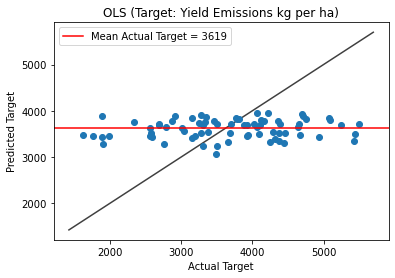

Lasso
MAE on test data: 765.663023753045


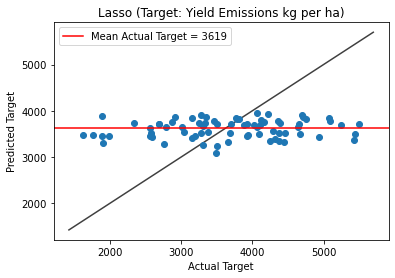

Ridge
MAE on test data: 761.5884185020884


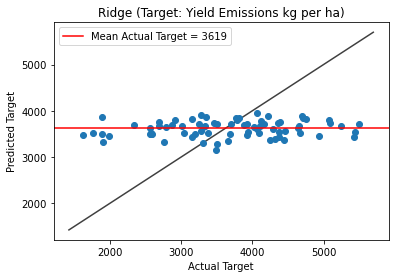

ElasticNet
MAE on test data: 765.7247023228455


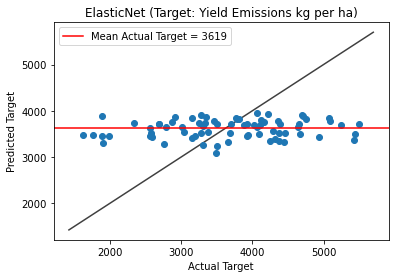

SVR
MAE on test data: 772.3776148788105


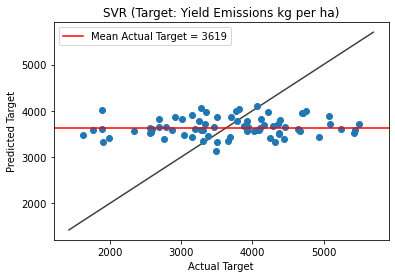

Lightgbm
MAE on test data: 750.8545476997581


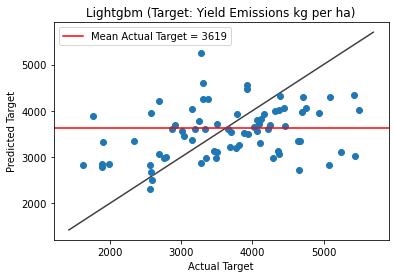

GBR
MAE on test data: 779.3611542778708


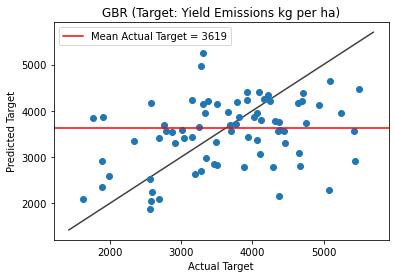

XGBoost
MAE on test data: 761.1898294536196


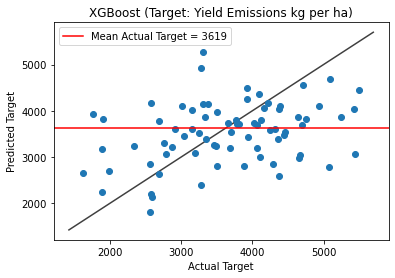

In [19]:
for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))
    fig, ax = plt.subplots()
    ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield Emissions kg per ha)')
    plt.legend()
    plt.show()

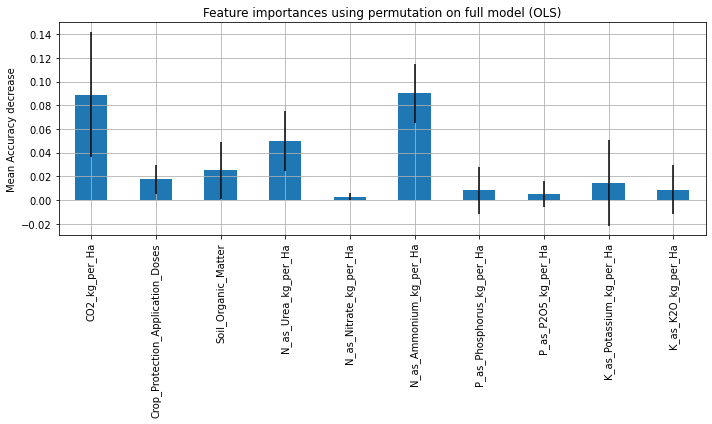

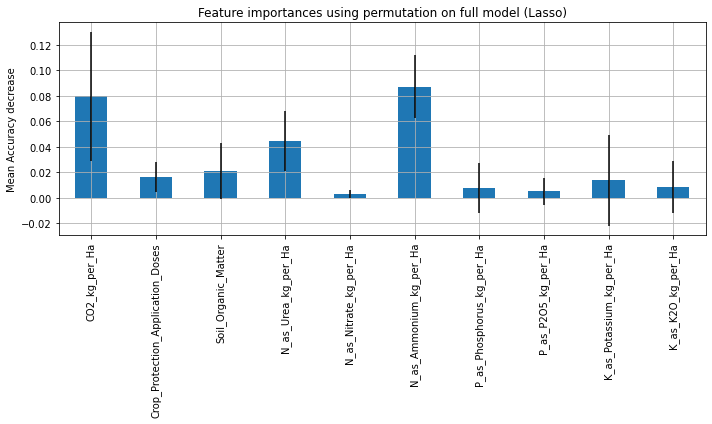

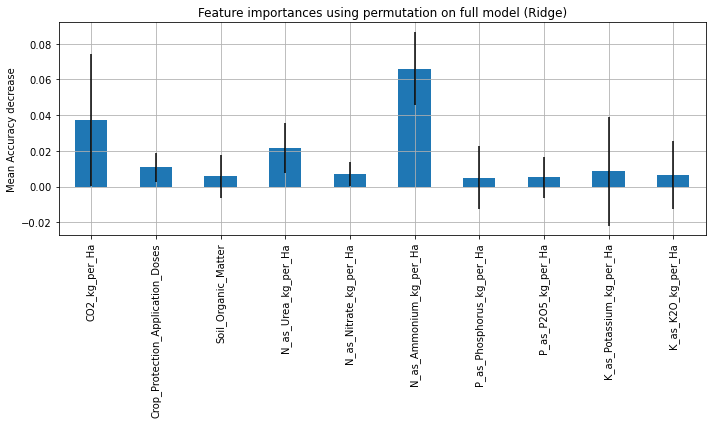

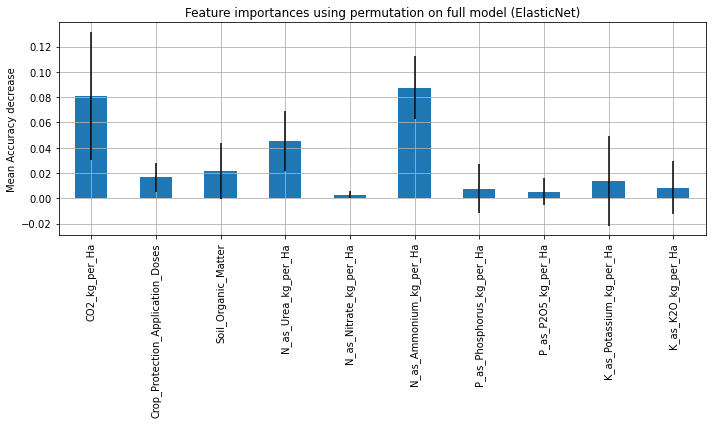

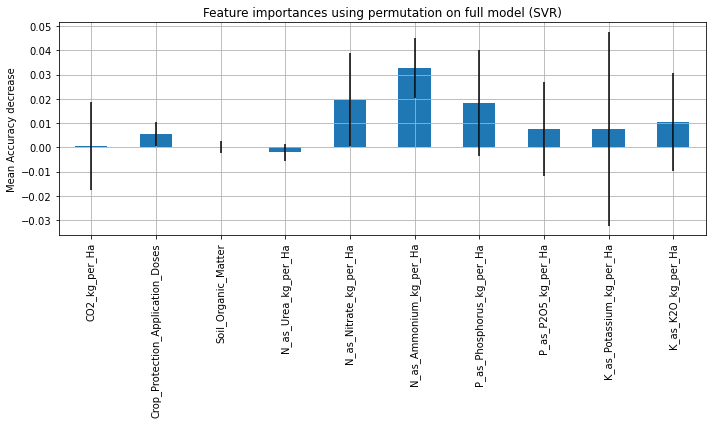

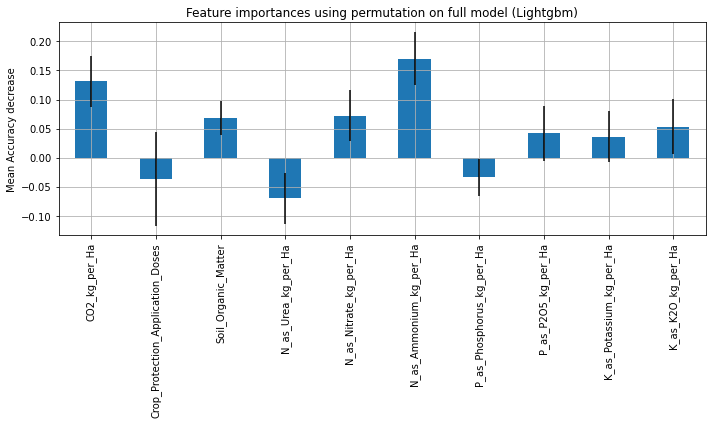

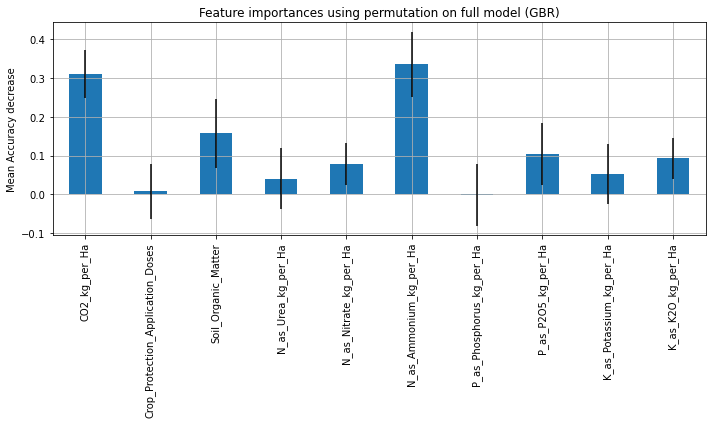

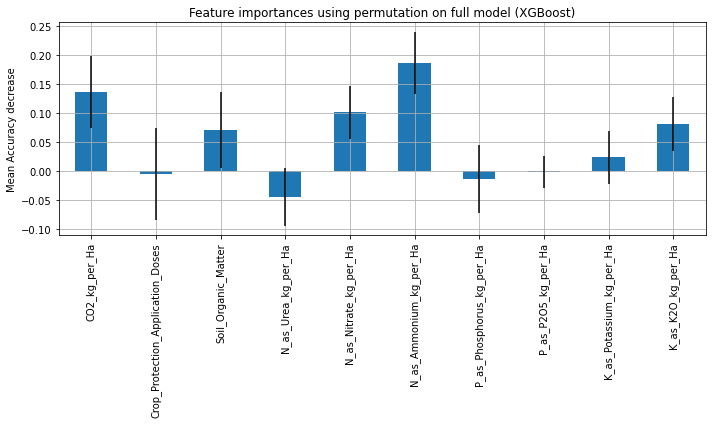

In [20]:
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha']).columns

    result = permutation_importance(
        fitted_models[i], X_test_Yield_kg_per_ha, y_test_Yield_kg_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

In [46]:
###############
### BUILD 2 ###
###############

#Yeo-Johnson Scaling
df = pd.read_csv('/mnt/Datasets/merged_df_1_27_23.csv').drop(columns = ['Unnamed: 0'])
df = df.drop(columns = ['Field_Name'])[['Yield_kg_per_Ha', 'CO2_kg_per_Ha']]

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df, test_size = 0.2, random_state = 60)

#x values
X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])
X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])

standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)

power_transform_X = PowerTransformer(standardize = True).fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = power_transform_X.transform(X_train_Yield_kg_per_ha)

X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)
X_test_Yield_kg_per_ha = power_transform_X.transform(X_test_Yield_kg_per_ha)

#y_values
y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()

y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))

y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)

power_transform_y = PowerTransformer(standardize = False).fit(y_train_Yield_kg_per_ha)

y_train_Yield_kg_per_ha = power_transform_y.transform(y_train_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = power_transform_y.transform(y_test_Yield_kg_per_ha)

# plt.figure()
# plt.hist(y_train_Yield_kg_per_ha)

In [47]:
####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []

for model in models:
    fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[22:27:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


OLS
MAE on test data: 839.8144990616076


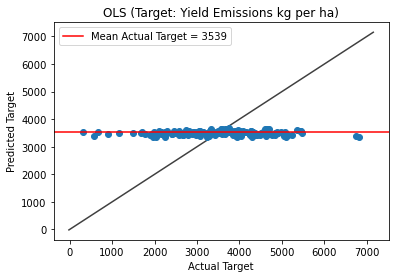

Lasso
MAE on test data: 839.8178150843596


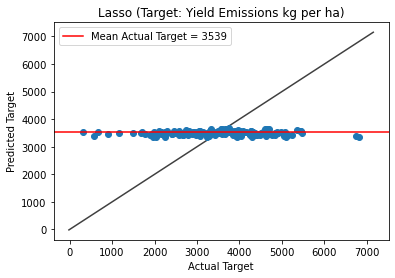

Ridge
MAE on test data: 839.9060278364045


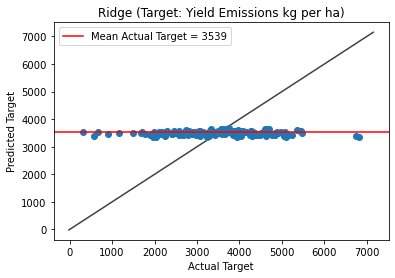

ElasticNet
MAE on test data: 839.8198798535705


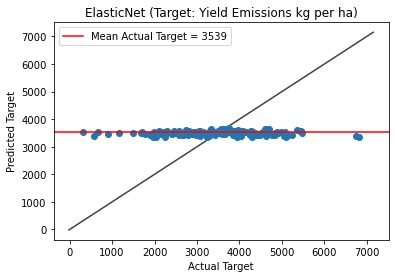

SVR
MAE on test data: 839.4686465637803


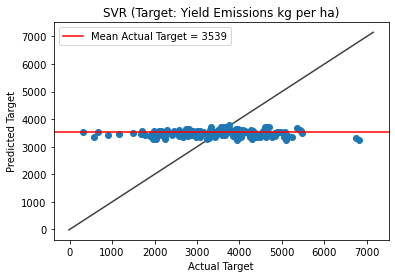

Lightgbm
MAE on test data: 917.8682835039561


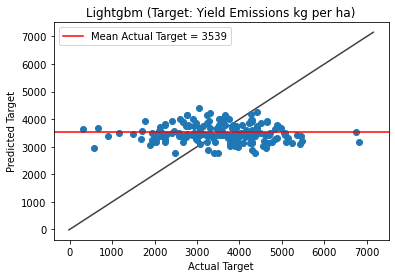

GBR
MAE on test data: 1039.7286921645452


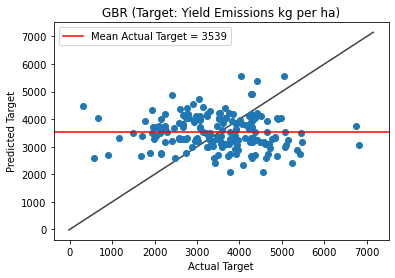

XGBoost
MAE on test data: 1005.5274573910441


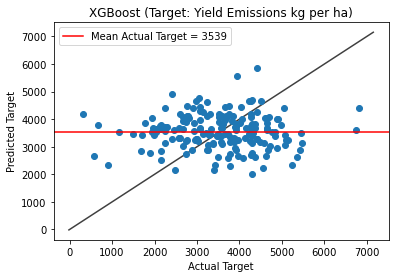

In [48]:
for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))
    fig, ax = plt.subplots()
    ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield Emissions kg per ha)')
    plt.legend()
    plt.show()

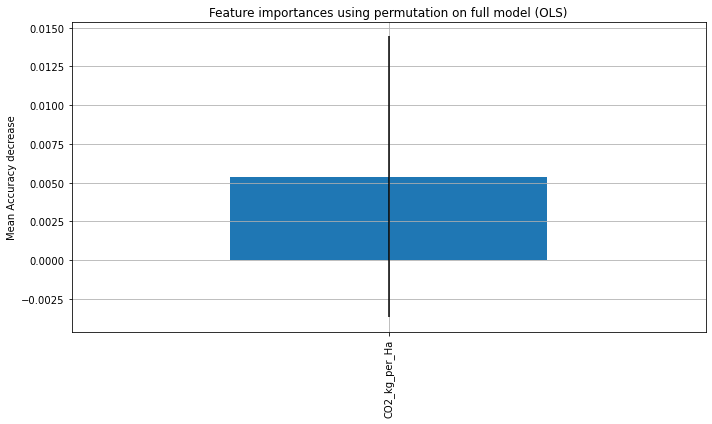

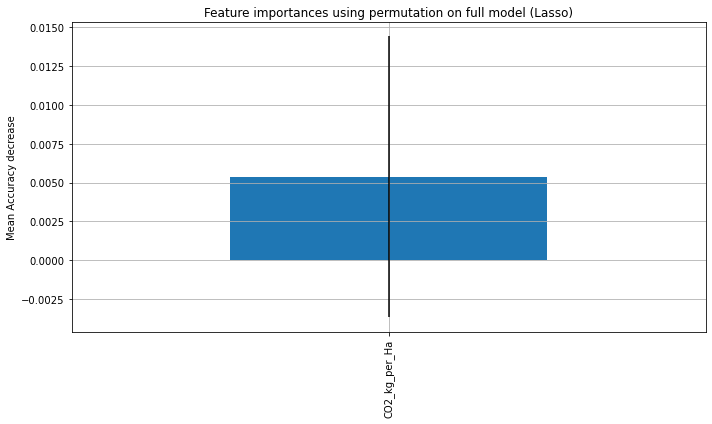

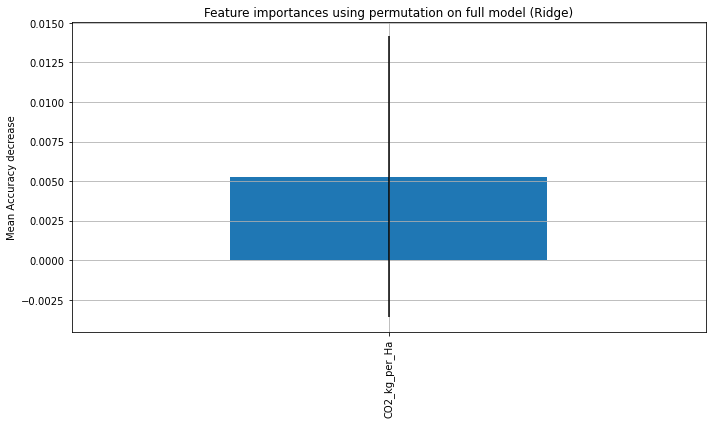

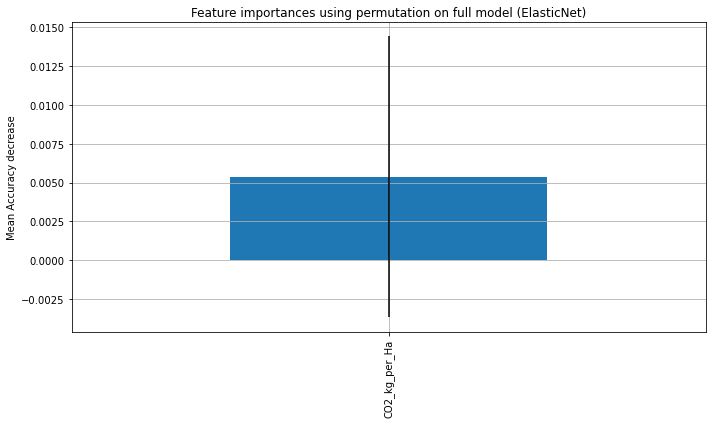

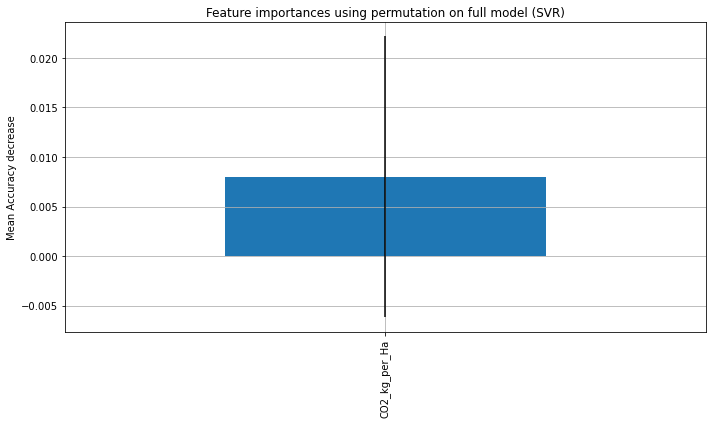

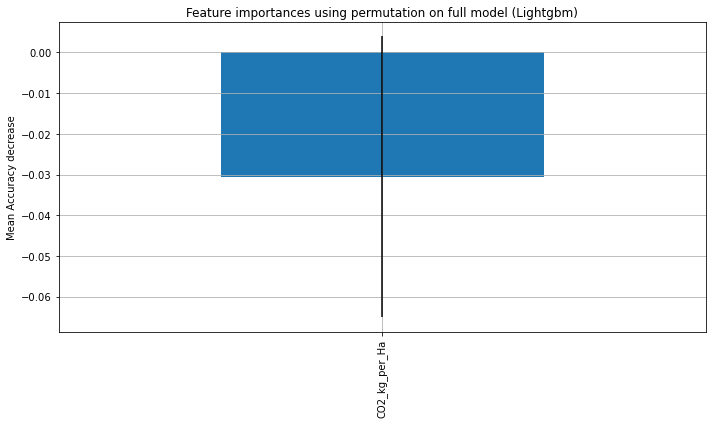

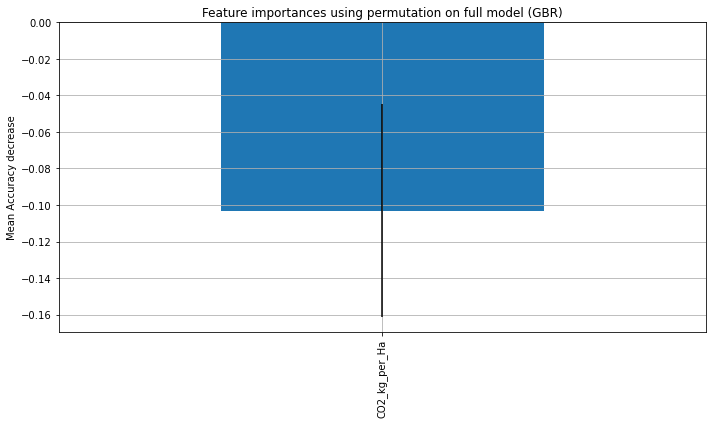

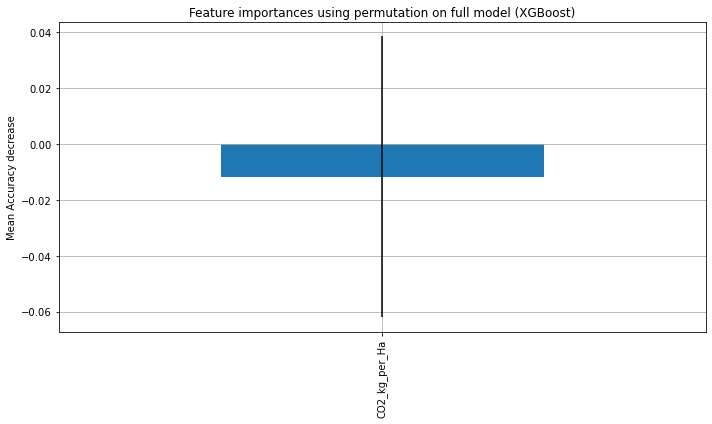

In [49]:
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha']).columns

    result = permutation_importance(
        fitted_models[i], X_test_Yield_kg_per_ha, y_test_Yield_kg_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()